# Predicting House Sale Prices Using Regression

by **Young Hun Ji**

May 17, 2021

!["auto1"](cover.jpg "cover")

## Abstract

In this project, I trained a regression model for predicting house sale prices in King County, Washington, U.S. The dataset consists of data on __*N* = 21,613__ house sales from May 2014 to May 2015 and was obtained from *Kaggle* via the following link: ["House Sales in King County, USA" Kaggle Dataset](https://www.kaggle.com/harlfoxem/housesalesprediction).

After an initial exploration of the dataset, **17 features** were selected based on their strength of correlation with the target variable (i.e., price). Subsequently, the dataset was split into training (75%) and testing (25%) sets.

Using the training dataset, regression model instances with varying **polynomial** degrees (from 1 to 3), regularization types (i.e., **ridge, lasso, elastic net**), and the **XGBoost** technique were developed and compared. All hyperparameters were tuned using **5-fold cross validation** and **Bayesian optimization** (in the case of XGBoost regression). Based on a comparison of the models' mean CV scores (specifically the coefficient of determination *R*<sup>2</sup> and root mean squared error [RMSE] scores), an XGBoost regression model was determined to be optimal (*R*<sup>2</sup> = .88, RMSE = 1.28e+05).

Evaluation of the final model using the testing dataset yielded the following metrics: __*R*<sup>2</sup> = .87, RMSE = 1.33e+05__. Limitations and future directions are discussed.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#chapter1">Column Descriptions</a><br><br>
2.  <a href="#chapter2">Exploratory Data Analysis</a><br>
     * 2.1 <a href="#chapter2.1">Loading and Inspecting the Dataset</a><br>
     * 2.2 <a href="#chapter2.2">Histograms</a><br>
     * 2.3 <a href="#chapter2.3">Scatterplots</a><br>
     * 2.4 <a href="#chapter2.4">Box Plots</a><br>
     * 2.5 <a href="#chapter2.5">Correlation Heat Map</a><br>
     * 2.6 <a href="#chapter2.6">Feature Scaling and Data Splitting</a><br><br>
3.  <a href="#chapter3">Model Development and Parameter-Tuning Via Cross Validation</a><br>
     * 3.1 <a href="#chapter3.1">Multiple Linear Regression</a><br>
     * 3.2 <a href="#chapter3.2">Polynomial Regression</a><br>
     * 3.3 <a href="#chapter3.3">Ridge Regression</a><br>
     * 3.4 <a href="#chapter3.4">Lasso Regression</a><br>
     * 3.5 <a href="#chapter3.5">Elastic Net Regression</a><br>
     * 3.6 <a href="#chapter3.6">XGBoost Regression</a><br>
     * 3.7 <a href="#chapter3.7">Summary of Evaluation Metrics Using the Training Data</a><br><br>
4.  <a href="#chapter4">Final Model Evaluation</a><br>
     * 4.1 <a href="#chapter4.1">Evaluation Metrics Using the Testing Data</a><br>
     * 4.2 <a href="#chapter4.2">Plot of the Distribution of Actual Versus Predicted Values</a><br>
     * 4.3 <a href="#chapter4.3">Plot of Residuals from Fitted Regression</a><br>
     * 4.4 <a href="#chapter4.4">Limitations and Future Directions</a>
    </font>
    </div>

## 1. Column Descriptions <a class="anchor" id="chapter1"></a>

***A brief description of all columns in the dataset:***

<b>id</b>: Unique identifier

<b> date</b>: Date house was sold

<b>price</b>: Price is prediction target

<b>bedrooms</b>: Number of bedrooms

<b>bathrooms</b>: Number of bathrooms

<b>sqft_living</b>: Square footage of the home

<b>sqft_lot</b>: Square footage of the lot

<b>floors</b>: Total floors (levels) in house

<b>waterfront</b>: House which has a view to a waterfront (1 = "waterfront", 0 = "no waterfront")

<b>view</b>: Number of times the house has been viewed

<b>condition</b>: How good the condition is overall

<b>grade</b>: Overall grade given to the housing unit, based on King County grading system

<b>sqft_above</b>: Square footage of house apart from basement

<b>sqft_basement</b>: Square footage of the basement

<b>yr_built</b>: Built Year

<b>yr_renovated</b>: Year when house was renovated

<b>zipcode</b>: Zip code

<b>lat</b>: Latitude coordinate

<b>long</b>: Longitude coordinate

<b>sqft_living15</b>: Living room area in 2015 (implies some renovations). This might or might not have affected the lot size area

<b>sqft_lot15</b>: Lot size area in 2015 (implies some renovations)

## 2. Exploratory Data Analysis<a class="anchor" id="chapter2"></a>

Prior to loading the dataset, I imported all dependencies required for the analysis:

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
sns.set_theme(style="whitegrid")
%matplotlib inline
seed = 50

### 2.1 Loading and Inspecting the Dataset<a class="anchor" id="chapter2.1"></a>

After downloading the dataset from *Kaggle* (Link to dataset: [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction)), I loaded the csv file as follows:

In [2]:
file_name='kc_house_data.csv'
df=pd.read_csv(file_name)

Viewing the first five rows:

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Checking the shape:

In [4]:
df.shape

(21613, 21)

Checking if there are missing values—there are none: 

In [5]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Checking if there are duplicate values—there are none:

In [6]:
df.duplicated().sum()

0

Before proceeding, I dropped the columns `id`, `date`, and `zipcode`, as they are not useful for the purpose of this analysis.<sup>*</sup><br><br><sup>*</sup>*Note*: Theoretically, the date of sale *could* have an impact on price (for example, house sale prices may be consistently higher on certain times of the week, month, or year), but I disregard this possibility for the purpose of this analysis.

In [7]:
df.drop('id', axis=1, inplace = True)
df.drop('date', axis=1, inplace = True)
df.drop('zipcode', axis=1, inplace = True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503


### 2.2 Histograms<a class="anchor" id="chapter2.2"></a>

To inspect the frequency distribution of each variable, I first inspected descriptive statistics from the `describe` function as follows:

In [8]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


Next, I created histograms (and KDEs) for all variables:

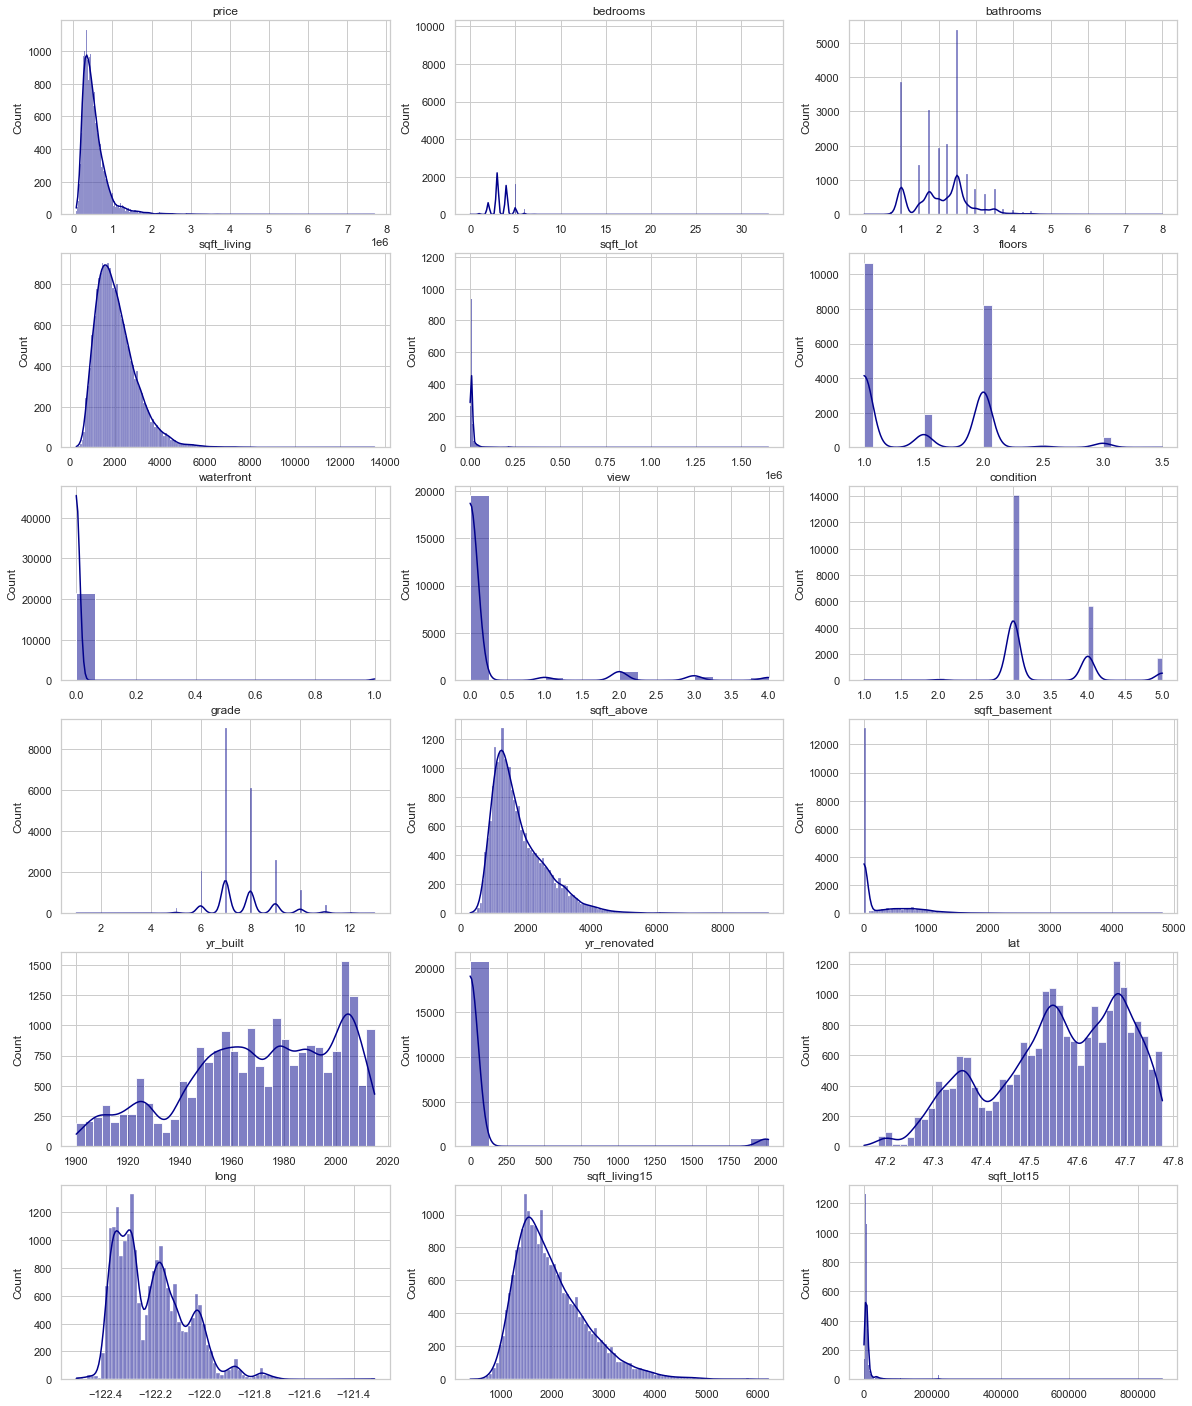

In [9]:
# Setting the number of rows and columns in the plotting grid
n_rows=6
n_cols=3

# Creating the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (20, 25))

for i, column in enumerate(df.columns):
    sns.histplot(df[column],ax=axes[i//n_cols,i%n_cols], 
                 kde = True, color = "darkblue").set(xlabel=None, title = column)

As shown above, most of the continuous variables, such as **"price"** and **"sqft_living,"** were roughly *normally distributed* (i.e., bell-shaped), but with a *heavy right tail* (i.e., right skew). This implies the presence of outliers for these variables, but this was to be expected given the context, where there will always be a small proportion of houses that are exceptionally large, luxurious, and expensive. As such, I decided to retain all data points instead of removing the outliers.<br><br>One notable distribution was that of **"yr_renovated"** (i.e., the year of renovation), where a majority of the data points had a value of "0," indicating that there was no renovation in recent history. Given this, I later decided to *dichotomize* the "yr_renovated" variable (1 = renovated, 0 = not renovated). 

### 2.3 Scatterplots<a class="anchor" id="chapter2.3"></a>

I decided to visually inspect the relationship between **"price"** and each of the following continuous variables: 
* "sqft_living"
* "sqft_lot" 
* "sqft_above"
* "sqft_basement"
* "sqft_living15"
* "sqft_lot15" 
* "yr_built" 
* "lat" 
* "long"

*(Note that I excluded "yr_renovated" from the list above, as I decided to dichotomize the variable and treat it as discrete instead.)*

To do this, I created scatterplots for price and each of the variables above, along with the regression lines:

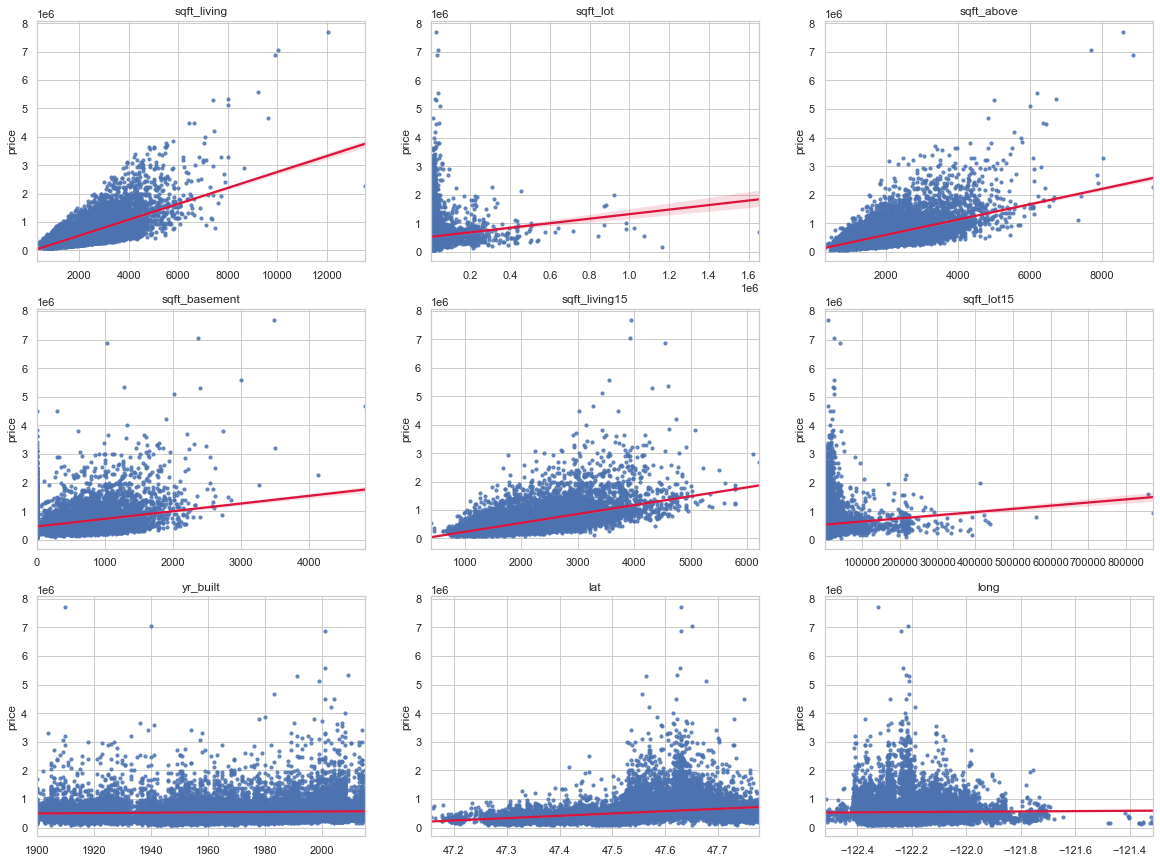

In [10]:
# Creating a list of continuous variables (excluding "yr_renovated")
columns_cont =["sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "sqft_living15", "sqft_lot15", "yr_built", "lat", "long"] 

# Setting the number of rows and columns in the plotting grid
n_rows=3
n_cols=3

# Creating the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (20, 15))

for i, column in enumerate(columns_cont):
    sns.regplot(x = column, y = "price", data = df, 
                ax=axes[i//n_cols,i%n_cols], 
                scatter_kws={'s' : 10}, 
                line_kws={'color': 'crimson'}).set(xlabel=None, title = column)

As shown above, some variables appeared to have fairly linear positive relationships with price (e.g., sqft_living), whereas the linearity of other relationships were less clear (e.g., yr_built).

Overall, it was not entirely clear from the plots alone whether *all* or *some* of the variables, if any, have a significant linear (or non-linear) relationship with price.

### 2.4 Boxplots<a class="anchor" id="chapter2.4"></a>

Additionally, I decided to visually inspect the relationship between "price" and each of the following discrete variables:

* "bedrooms"
* "bathrooms"
* "grade"
* "waterfront"
* "view"
* "condition"
* "floors"
* "renovated"<sup>*</sup>

<sup>*</sup>*Note*: Prior to creating the boxplots, I created a new, dichotomous variable **"renovated"** (1 = renovated, 0 = not renovated) using the original variable "yr_renovated" as shown below:

In [11]:
# Creating an empty list
list_ = []

# Populating the list
for x in df['yr_renovated']:
    if x!=0:
        list_.append(1)
    else:
        list_.append(0)
        
# Appending to new binary column named "renovated"
df['renovated'] = list_

# Dropping the old column
df.drop('yr_renovated', axis=1, inplace = True)

# Viewing the first five rows
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,47.5112,-122.257,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,47.7210,-122.319,1690,7639,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,47.7379,-122.233,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,47.5208,-122.393,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,47.6168,-122.045,1800,7503,0


I then created boxplots comparing prices across values for each of the variables above.

First, a boxplot for **"bathrooms"**:

<AxesSubplot:title={'center':'Comparison of Price by Number of Bathrooms'}, xlabel='bathrooms', ylabel='price'>

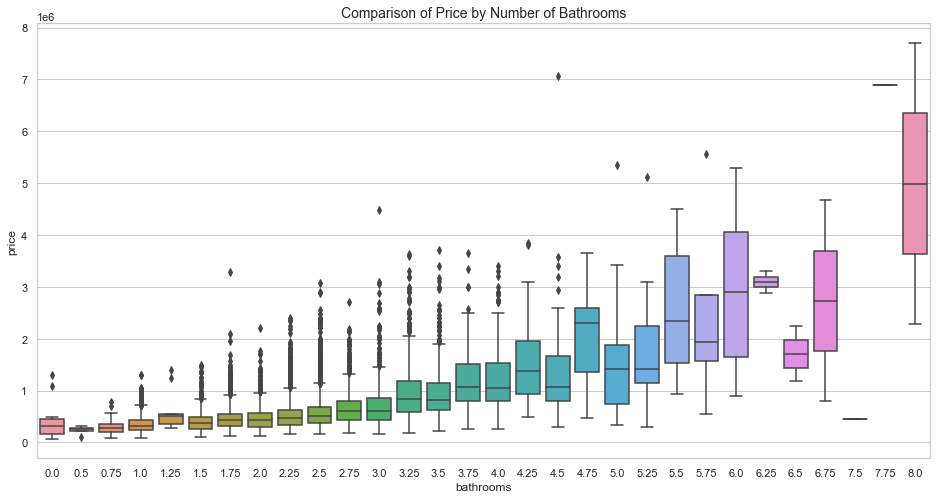

In [12]:
plt.figure(figsize=(16, 8))
plt.title("Comparison of Price by Number of Bathrooms", fontsize = 14)
sns.boxplot(x="bathrooms", y="price", data=df)

Next, a boxplot for **"bedrooms"**

<AxesSubplot:title={'center':'Comparison of Price by Number of Bedrooms'}, xlabel='bedrooms', ylabel='price'>

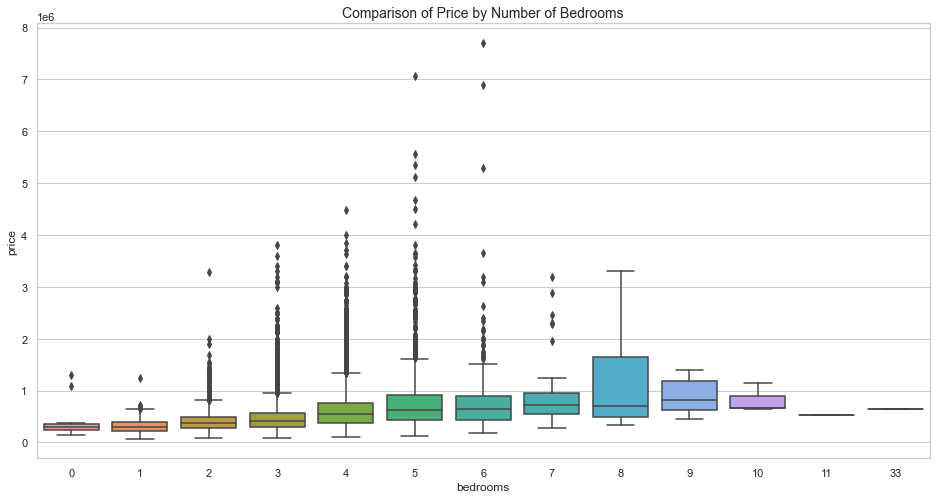

In [13]:
plt.figure(figsize=(16, 8))
plt.title("Comparison of Price by Number of Bedrooms", fontsize = 14)
sns.boxplot(x="bedrooms", y="price", data=df)

And finally the boxplots for all other discrete variables:

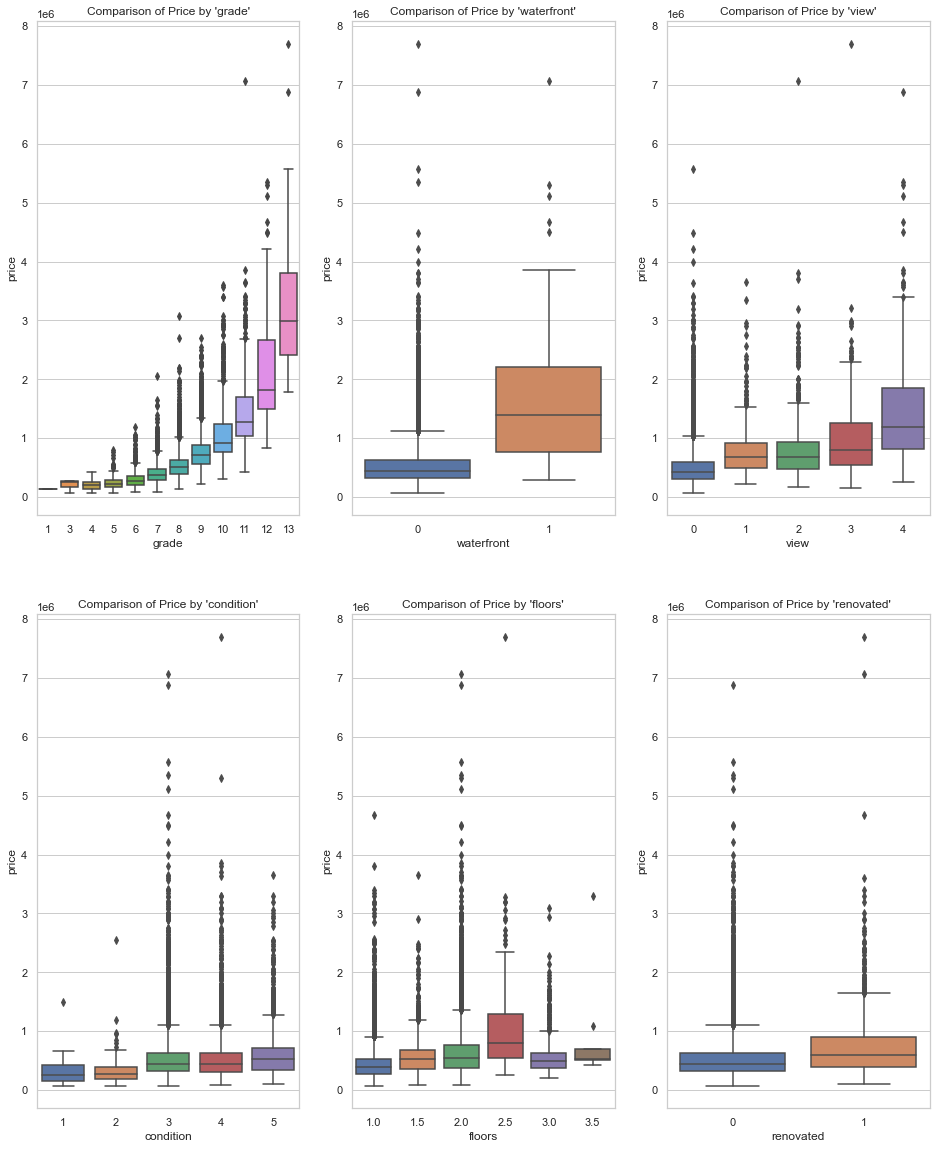

In [14]:
# Creating a list of discrete variables (excluding "yr_renovated")
columns_disc = ["grade", "waterfront", "view", "condition", "floors", "renovated"]

# Setting the number of rows and columns in the plotting grid
n_rows=2
n_cols=3

# Creating the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (16, 20))

for i, column in enumerate(columns_disc):
    sns.boxplot(x = column, y = "price", data = df,
                         ax=axes[i//n_cols,i%n_cols]).set(title = "Comparison of Price by '{0}'".format(column))

As with the continuous variables, most of the discrete variables appeared to exhibit systematic differences in price across values. Some resembled a somewhat linear relationship (e.g., number of bathrooms), whereas the association was less clear for others. In particular, the association between **grade** and price resembled a positive non-linear relationship.

Overall, however, it was not entirely clear from the plots alone whether the variables have a significant relationship with price.

### 2.5 Correlation Heatmap<a class="anchor" id="chapter2.5"></a>

To examine the strength of the relationships among variables, I created a correlation heatmap as follows:

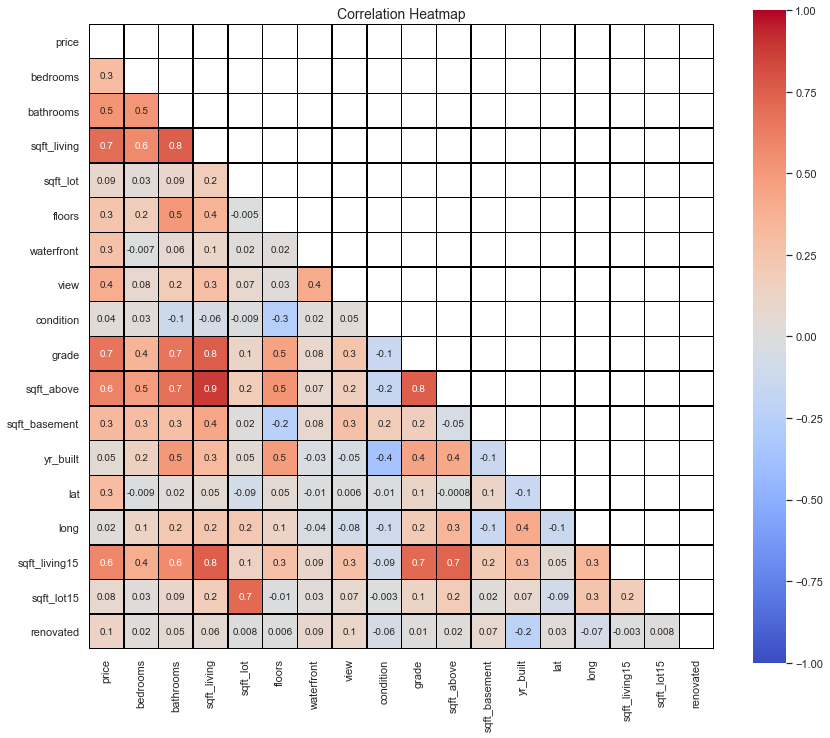

In [15]:
# Compute the correlation matrix 
corr_all = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize = (14, 12))
plt.title("Correlation Heatmap", fontsize = 14)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, annot = True, fmt= '.1g', vmin =-1, vmax = 1, center = 0,
            square = True, linecolor = 'black', linewidths = .5, cmap = "coolwarm")
plt.show()

Next, I created table displaying each variable's correlation with price and associated p-value:

In [16]:
# List of variables 
measures =["long", "condition", "yr_built", "sqft_lot15", "sqft_lot", "renovated", "floors", "waterfront",
           "lat" ,"bedrooms" ,"sqft_basement" ,"view" ,"bathrooms","sqft_living15","sqft_above","grade","sqft_living"] 

# Empty lists (for correlations and p-values)
correlations = []
p_values = []

# Populating the lists

for measure in measures:
    correlations.append("%.2f"%stats.pearsonr(df[measure], df['price'])[0])
    p_values.append("%.2f"%stats.pearsonr(df[measure], df['price'])[1])
    
# Appending to a new table
corr_table = pd.DataFrame()
corr_table['measure'] = measures
corr_table['correlation'] = correlations
corr_table['p_value'] = p_values
corr_table

,measure,correlation,p_value
0,long,0.02,0.00
1,condition,0.04,0.00
2,yr_built,0.05,0.00
3,sqft_lot15,0.08,0.00
4,sqft_lot,0.09,0.00
5,renovated,0.13,0.00
6,floors,0.26,0.00
7,waterfront,0.27,0.00
8,lat,0.31,0.00
9,bedrooms,0.31,0.00


All of the correlations were statistically significant (*p* < .05)—not surprising given the large sample size.

### 2.6 Feature Scaling and Data Splitting<a class="anchor" id="chapter2.6"></a>

At this point, I decided to use **all** of the features as predictors because:
1. The **visual inspections** implied a systematic relationship between price and most of the features.
2. The **correlations** between price and each of the features were significant.
3. The **theoretical/conceptual** rationale linking each of the predictors to the target variable were plausible.

Next, I decided to scale the features before splitting the data into training and testing sets. Specifically, I used *z-standardization* to standardize all features, i.e., subtracting the mean from each data point and then dividing that number by the standard deviation; z = (x - u) / s using the `StandardScaler` function.

I standardized the features in order to mitigate *overfitting*, which is a concern especially when there is high *multicollinearity* among the predictors, as was the case in this dataset (e.g., the correlation between 'sqft_above' and 'sqft_living' was *r* = .88). Multicolollinearity is exacerbated when performing *polynomial transformations*, which in turn exacerbates the risk of overfitting. Hence, I standardized all features prior to building the regression models.

After scaling the features, I split the data into training (75%) and testing (25%) datasets.

In [17]:
# List of features
features =["long", "condition", "yr_built", "sqft_lot15", "sqft_lot", "renovated", "floors", "waterfront",
           "lat" ,"bedrooms" ,"sqft_basement" ,"view" ,"bathrooms","sqft_living15","sqft_above","grade","sqft_living"]    

# Defining feature set and target variable
X = df[features]
Y = df['price']

# Feature scaling via z-standardization
X_columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = X_columns

# Splitting data into training (75%) and testing (25%) sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)

# Inspecting shapes
print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 5404
number of training samples: 16209


## 3. Model Development and Parameter-Tuning Via Cross Validation<a class="anchor" id="chapter3"></a>

I tested a series of regression models of varying polynomial degrees (from 1 to 3) and different regularization types (ridge, lasso, and elastic net) and strengths. First, the optimal polynomial degree was chosen, and then different regularization parameters were evaluated and compared. 

For model selection and hyperparameter-tuning (e.g., regularization penalty), I used *k*-fold cross validation. This process splits the training dataset further into *k* equal-sized subsamples or *folds*, and then uses *k*-1 folds to train the model and the remaining fold (i.e., the "validation set") to evaluate the model. The process is then repeated sequentially for each combination of folds until each of the *k* folds have been used once as the validation set. I used 5-fold cross validation in this analysis.

The figure below depicts the 5-fold cross validation process. 

!["auto1"](cross_validation_process.png "cross validation process")

### 3.1 Multiple Linear Regression<a class="anchor" id="chapter3.1"></a>

First, I created a multiple linear regression model using all features. I evaluated the model by computing **mean cross validation (CV) scores**. Specifically, I computed the coefficient of determination _**R<sup>2</sup>**_ (the higher the better), and the root mean squared error **RMSE** (the lower the better), averaged across the 5 folds.

In [18]:
# Creating a multiple regression object
mlr = LinearRegression()

# Training the model
mlr.fit(x_train, y_train)

# Computing the mean R-squared across folds
r2_mlr = cross_val_score(mlr, x_train, y_train, cv = 5).mean()
print("R-squared =", "%.4f"%r2_mlr)

# Computing the mean RMSE across folds
rmse_mlr = -1 * cross_val_score(mlr, x_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print("RMSE =", "{:.4e}".format(rmse_mlr))

R-squared = 0.6923
RMSE = 2.0210e+05


### 3.2 Polynomial Regression<a class="anchor" id="chapter3.2"></a>

Next, I compared models using different polynomial degrees from 1 to 3. I chose the optimal polynomial degree based on a comparison of mean _**R<sup>2</sup>**_ scores across folds

In [19]:
# Comparing the mean R-squared values for models with polynomial degrees 1, 2, and 3
degrees = [1, 2, 3]
for deg in degrees:
    pr=PolynomialFeatures(deg)
    x_train_pr=pr.fit_transform(x_train)
    print("For degree = {0}, mean CV score (R-squared) equals {1} ".format(deg, "%.4f"%cross_val_score(mlr, x_train_pr, y_train, cv = 5).mean()))

For degree = 1, mean CV score (R-squared) equals 0.6923 
For degree = 2, mean CV score (R-squared) equals 0.7925 
For degree = 3, mean CV score (R-squared) equals -198378031117298688.0000 


As shown, the _**R<sup>2</sup>**_ score was substantially larger for **degree = 2** compared to the others.

So I chose degree = 2, and I defined "x_train_pr" as the 2nd degree polynomial transformation of the training dataset.

In [20]:
# Transforming the training data
pr=PolynomialFeatures(2)
x_train_pr=pr.fit_transform(x_train)

# Training the polynomial regression model
mlr.fit(x_train_pr, y_train)

# Computing the mean R-squared across folds
r2_mlr2 = cross_val_score(mlr, x_train_pr, y_train, cv = 5).mean()
print("R-squared =", "%.4f"%r2_mlr2)

# Computing the mean RMSE across folds
rmse_mlr2 = -1 * cross_val_score(mlr, x_train_pr, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print("RMSE =", "{:.4e}".format(rmse_mlr2))

R-squared = 0.7925
RMSE = 1.6537e+05


### 3.3 Ridge Regression<a class="anchor" id="chapter3.3"></a>

I then compared the polynomial regression model but with different regularization types and strengths. Regularization imposes a "penalty" on regression coefficients in order to mitigate overfitting to the training data.

First, I used ridge regression (with polynomial degree 2), which penalizes the regression coefficients while still keeping them above 0 (i.e., all features are retained as predictors) unlike lasso regression where coefficients are allowed to be penalized all the way down to zero. The parameter _**λ**_ (referred to as `alpha` in Python) indicates the strength of the regularization penalty.

I examined the the mean CV score (_R<sup>2</sup>_) to choose the optimal _λ_ value from a range of sixty uniform values from 1 to 1500. To do this, I used the `RidgeCV` function which has cross-validation built in.

In [21]:
# Defining a ridge regression object with a range of alpha values and 5 folds
RidgeModel = RidgeCV(alphas= list(range(1, 1500, 25)), cv = 5)

# Training the models
RidgeModel.fit(x_train_pr, y_train)

# Showing the optimal λ value
RidgeModel.alpha_

976

So __*λ* = 976__ yields the highest mean CV score.<br>
Below is a plot comparing the mean CV scores across _λ_ values:

<AxesSubplot:title={'center':'Mean Cross Validation Scores Across λ Values'}, xlabel='Regularization Parameter (λ)', ylabel='Mean Cross Validation Score (R-Squared)'>

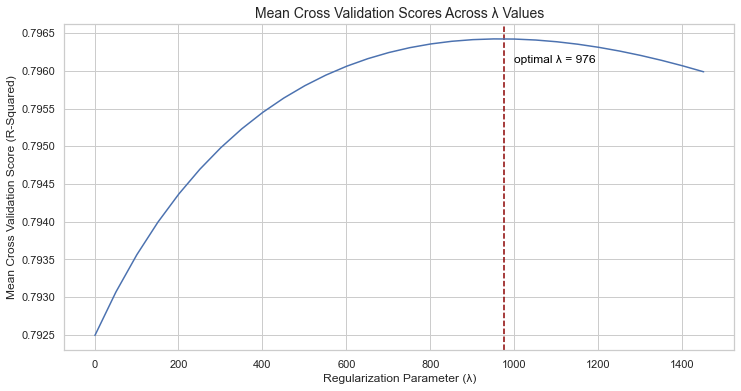

In [22]:
# A range of alpha values
alphas = list(range(1, 1500, 50))

# Settings for the plot
plt.figure(figsize=(12, 6))
plt.title("Mean Cross Validation Scores Across λ Values", fontsize = 14)
plt.axvline(x= 976, linestyle="--", color = "darkred")
plt.text(1000, 0.7961, "optimal λ = 976", horizontalalignment='left', fontsize = 12, color='black')
plt.xlabel("Regularization Parameter (λ)", fontsize = 12)
plt.ylabel("Mean Cross Validation Score (R-Squared)", fontsize = 12)

# Plotting the scores
scores = [cross_val_score(Ridge(alpha), x_train_pr, y_train, cv=5).mean() for alpha in alphas]
sns.lineplot(x= alphas, y = scores)

Next, creating a ridge regression object with *λ* = 976:

In [23]:
RidgeTuned = Ridge(alpha = 976)

Computing the mean CV scores:

In [24]:
# Training the model
RidgeTuned.fit(x_train_pr, y_train)

# Computing the mean R-squared across folds
r2_ridge = cross_val_score(RidgeTuned, x_train_pr, y_train, cv = 5).mean()
print("R-squared =", "%.4f"%r2_ridge)

# Computing the mean RMSE across folds
rmse_ridge = -1 * cross_val_score(RidgeTuned, x_train_pr, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print("RMSE =", "{:.4e}".format(rmse_ridge))

R-squared = 0.7964
RMSE = 1.6369e+05


As shown, the mean CV scores **improved slightly** when applying ridge regularization compared to the polynomial regression model without regularization (i.e., marginally larger *R<sup>2</sup>* and smaller RMSE).

### 3.4 Lasso Regression<a class="anchor" id="chapter3.4"></a>

Second, I used lasso regression (with polynomial degree 2), which, like ridge regression, applies a "penalty" on regression coefficients in order to mitigate overfitting. But unlike ridge regression, lasso regression allows regression coefficients to be penalized all the way down to zero, and thus can potentially reduce the number of features ultimately retained as predictors. The parameter λ (or `alpha`) indicates the strength of the regularization penalty.

As before, I examined the the mean CV score (_R<sup>2</sup>_) to choose the optimal _λ_ value from a range of sixty uniform values from 1 to 1500. To do this, I used the `LassoCV` function which has cross-validation built in.

In [25]:
# Defining a lasso regression object with a range of alpha values and 5 folds
LassoModel = LassoCV(alphas= list(range(1, 1500, 25)), cv = 5, max_iter=11000)

# Training the models
LassoModel.fit(x_train_pr, y_train)

# Showing the optimal λ value
LassoModel.alpha_

901

So __*λ* = 901__ yields the highest mean CV score.<br>Next, creating a ridge regression object with *λ* = 901:

In [26]:
LassoTuned = Lasso(alpha = 901, max_iter = 1100)

In [27]:
# Training the model
LassoTuned.fit(x_train_pr, y_train)

# Computing the mean R-squared across folds
r2_lasso = cross_val_score(LassoTuned, x_train_pr, y_train, cv = 5).mean()
print("R-squared =", "%.4f"%r2_lasso)

# Computing the mean RMSE across folds
rmse_lasso = -1 * cross_val_score(LassoTuned, x_train_pr, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print("RMSE =", "{:.4e}".format(rmse_lasso))

R-squared = 0.7968
RMSE = 1.6359e+05


As shown, the mean CV scores **improved** when applying lasso regularization compared to the previous models, **albeit very slightly**—not likely to make impactful difference in practice.

### 3.5 Elastic Net Regression<a class="anchor" id="chapter3.5"></a>

Third, I used elastic net regression (with polynomial degree 2), which is essentially a hybrid of ridge and lasso regularization. In elastic net regression, there are *two* hyperparameters than needs to be tuned: 

* First, the `alpha` parameter is a constant that multiplies the ridge and lasso penalty terms.
* Second, the `l1_ratio` represents the ratio of ridge and lasso regression penalties. As such, `l1_ratio = 0` represents ridge regression penalty only; `l1_ratio = 1` represents lasso regression penalty only; and `0 < l1_ratio < 1` represents a combination of ridge and lasso regression penalties.

I examined the the mean CV score (_R<sup>2</sup>_) to choose (a) the optimal alpha value from a range of sixty uniform values from 1 to 1500 and (b) the optimal l1 ratio from a range of nine uniform values from 0.1 to 0.9. To do this, I used the `ElasticNetCV` function which has cross-validation built in.

In [28]:
# Defining an elastic net regression object with a range of alpha values, range of l1 ratios, and 5 folds
ElasticModel = ElasticNetCV(alphas= list(range(1, 1500, 25)), l1_ratio = np.linspace(0.1, 0.9, num= 9), cv = 5)

# Training the models
ElasticModel.fit(x_train_pr, y_train)

# Showing the optimal alpha value and l1 ratio
print(ElasticModel.alpha_)
print(ElasticModel.l1_ratio_)

1
0.9


So the optimum **alpha** and **l1 ratio** from the selected ranges were equal to **1 and 0.9**, respectively. Because the optimal l1 ratio was equal to the maximum value within the selected range of 0.1 to 0.9, this essentially indicates that combining ridge and lasso does not improve the model over using lasso only.

Next, creating an elastic net regression object with `alpha = 901` and `l1_ratio = 0.9`

In [29]:
ElasticTuned = ElasticNet(alpha = 1, l1_ratio = 0.9)

In [30]:
# Training the model
ElasticTuned.fit(x_train_pr, y_train)

# Computing the mean R-squared across folds
r2_elastic = cross_val_score(ElasticTuned, x_train_pr, y_train, cv = 5).mean()
print("R-squared =", "%.4f"%r2_elastic)

# Computing the mean RMSE across folds
rmse_elastic = -1 * cross_val_score(ElasticTuned, x_train_pr, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print("RMSE =", "{:.4e}".format(rmse_elastic))

R-squared = 0.7962
RMSE = 1.6376e+05


As expected, using elastic net regression yielded a **slightly worse model** than when using lasso regression (i.e., marginally smaller *R<sup>2</sup>* was smaller and higher RMSE). 

But overall, the mean CV scores do not vary substantially when applying any of the foregoing regularization penalties (i.e., ridge, lasso, and elastic net). In practice, they are not likely to make a substantial improvement over the polynomial model without regularization (**the *R<sup>2</sup>* differences are less than .005**).

### 3.6 XGBoost Regression<a class="anchor" id="chapter3.6"></a>

Finally, I used extreme gradient boost or XGBoost regression, which is an advanced gradient boosting algorithm with numerous advantages, such as regularization, computational efficiency, and high overall effectiveness. 

XGBoost uses numerous "booster parameters", and I selected the following parameters for tuning:

* max_depth
* eta (aka "learning rate")
* gamma
* reg_alpha
* reg_lambda
* subsample
* colsample_bytree
* min_child_weight

Details regarding all XGBoost hyperparameters can be found on the official documentation page: [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html).

In order to tune the foregoing parameters, I used **Bayesian optimization** using the `HyperOpt` library. This method uses information from past trials to inform the next set of hyperparameters to explore, making it more efficient, which is especially desirable when handling a large number of parameters.

In [31]:
# Defining the value range for all booster parameters
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'eta': hp.uniform('eta', 0.01, 0.5),
        'gamma': hp.uniform ('gamma', 0, 0.5),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 1),
        'n_estimators': 100,
        'seed': 50
    }

In [32]:
# Defining the model
def objective(space):
    XGBModel=XGBRegressor(max_depth = int(space['max_depth']),
                          gamma = space['gamma'],
                          eta = space['eta'],
                          reg_alpha = space['reg_alpha'],
                          reg_lambda = space['reg_lambda'],
                          min_child_weight= space['min_child_weight'],
                          colsample_bytree=int(space['colsample_bytree']),
                          subsample = space['subsample'],
                          n_estimators =100,
                          seed = 50)         
    
    # Computing the mean cv score   
    score = cross_val_score(XGBModel, x_train_pr, y_train, cv=5).mean()
    print ("SCORE:", score)
    return {'loss': -score, 'status': STATUS_OK}

In [33]:
# Running 100 evaluations to find the optimal parameters
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        rstate= np.random.RandomState(seed))

SCORE:                                                                                                                 
0.7674930688905528                                                                                                     
SCORE:                                                                                                                 
0.7756344797801835                                                                                                     
SCORE:                                                                                                                 
0.7670105016947448                                                                                                     
SCORE:                                                                                                                 
0.6447618922986222                                                                                                     
SCORE:                                  

In [34]:
# Showing the best parameters 
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.769390293007654, 'eta': 0.28512337159773893, 'gamma': 0.21813763480586612, 'max_depth': 4.0, 'min_child_weight': 0.7173431386681556, 'reg_alpha': 0.31581014767569393, 'reg_lambda': 0.07729291789870633, 'subsample': 0.9226443928590399}


In [35]:
# Creating an XGBoost object with optimized parameters
XGBTuned = XGBRegressor(max_depth = round(best_hyperparams['max_depth']),
                        gamma = best_hyperparams['gamma'],
                        eta = best_hyperparams['eta'],
                        reg_alpha = best_hyperparams['reg_alpha'],
                        reg_lambda = best_hyperparams['reg_lambda'],
                        min_child_weight = best_hyperparams['min_child_weight'],
                        colsample_bytree = best_hyperparams['colsample_bytree'],
                        subsample = best_hyperparams['subsample'],
                        n_estimators =100,
                        seed = 50
                       )

In [36]:
# Training the model
XGBTuned.fit(x_train_pr, y_train)

# Computing the mean R-squared across folds
r2_XGB = cross_val_score(XGBTuned, x_train_pr, y_train, cv = 5).mean()
print("R-squared =", "%.4f"%r2_XGB)

# Computing the mean RMSE across folds
rmse_XGB = -1 * cross_val_score(XGBTuned, x_train_pr, y_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print("RMSE =", "{:.4e}".format(rmse_XGB))

R-squared = 0.8769
RMSE = 1.2756e+05


As shown, the mean CV scores have **improved substantially** over that of all previous models.

### 3.7 Summary of Evaluation Metrics Using the Training Data<a class="anchor" id="chapter3.7"></a>

Below is a summary of mean CV scores for all of the models using the training data:

In [37]:
print("Multiple linear regression:\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_mlr, "%.2f"%rmse_mlr))
print("")
print("Polynomial regression (deg = 2):\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_mlr2, "%.2f"%rmse_mlr2))
print("")
print("Ridge regression (deg = 2, alpha = 976):\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_ridge, "%.2f"%rmse_ridge))
print("")
print("Lasso regression (deg = 2, alpha = 901):\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_lasso, "%.2f"%rmse_lasso))
print("")
print("Elastic net regression (deg = 2, alpha = 1, l1 ratio = 0.9):\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_elastic, "%.2f"%rmse_elastic))
print("")
print("XGBoost regression*:\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_XGB, "%.2f"%rmse_XGB))

Multiple linear regression:
 R-square = 0.6923, RMSE = 202098.14

Polynomial regression (deg = 2):
 R-square = 0.7925, RMSE = 165371.03

Ridge regression (deg = 2, alpha = 976):
 R-square = 0.7964, RMSE = 163693.16

Lasso regression (deg = 2, alpha = 901):
 R-square = 0.7968, RMSE = 163589.44

Elastic net regression (deg = 2, alpha = 1, l1 ratio = 0.9):
 R-square = 0.7962, RMSE = 163760.87

XGBoost regression*:
 R-square = 0.8769, RMSE = 127561.95


_Note_: Booster parameters: *max depth* = 4, *gamma* = 0.2181, *learning rate (eta)* = 0.2851, *alpha* = 0.3158, *lambda* = 0.0773, *min_child_weight* = 0.7173, *colsample_bytree* = 0.7694, *subsample* = 0.9226, *n_estimators* = 100

As shown, **the XGBoost regression model** yielded the highest __*R<sup>2</sup>* (.8769)__ and smallest __RMSE (127561.95)__. So I selected this as the final model.

## 4. Final Model Evaluation <a class="anchor" id="chapter4"></a>

Finally, I evaluated the models using the testing data.

### 4.1 Evaluation Metrics Using the Testing Data<a class="anchor" id="chapter4.1"></a>

In [38]:
# Transforming the testing data
x_test_pr=pr.fit_transform(x_test)

# Multiple linear regression
mlr.fit(x_train, y_train)
r2_mlr_test = mlr.score(x_test, y_test)
yhat_mlr = mlr.predict(x_test)
rmse_mlr_test = math.sqrt(mean_squared_error(y_test, yhat_mlr))

# Polynomial regression
mlr.fit(x_train_pr, y_train)
r2_mlr2_test = mlr.score(x_test_pr, y_test)
yhat_mlr2 = mlr.predict(x_test_pr)
rmse_mlr2_test = math.sqrt(mean_squared_error(y_test, yhat_mlr2))

# Ridge regression
RidgeTuned.fit(x_train_pr, y_train)
r2_ridge_test = RidgeTuned.score(x_test_pr, y_test)
yhat_ridge = RidgeTuned.predict(x_test_pr)
rmse_ridge_test = math.sqrt(mean_squared_error(y_test, yhat_ridge))

# Lasso regression
LassoTuned.fit(x_train_pr, y_train)
r2_lasso_test = LassoTuned.score(x_test_pr, y_test)
yhat_lasso = LassoTuned.predict(x_test_pr)
rmse_lasso_test = math.sqrt(mean_squared_error(y_test, yhat_lasso))

# Elastic net regression
ElasticTuned.fit(x_train_pr, y_train)
r2_elastic_test = ElasticTuned.score(x_test_pr, y_test)
yhat_elastic = ElasticTuned.predict(x_test_pr)
rmse_elastic_test = math.sqrt(mean_squared_error(y_test, yhat_elastic))

# XGBoost regression
XGBTuned.fit(x_train_pr, y_train)
r2_XGB_test = XGBTuned.score(x_test_pr, y_test)
yhat_XGB = XGBTuned.predict(x_test_pr)
rmse_XGB_test = math.sqrt(mean_squared_error(y_test, yhat_XGB))

In [39]:
print("Multiple linear regression:\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_mlr_test, "%.2f"%rmse_mlr_test))
print("")
print("Polynomial regression (deg = 2):\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_mlr2_test, "%.2f"%rmse_mlr2_test))
print("")
print("Ridge regression (deg = 2, alpha = 976):\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_ridge_test, "%.2f"%rmse_ridge_test))
print("")
print("Lasso regression (deg = 2, alpha = 901):\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_lasso_test, "%.2f"%rmse_lasso_test))
print("")
print("Elastic net regression (deg = 2, alpha = 1, l1 ratio = 0.9):\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_elastic_test, "%.2f"%rmse_elastic_test))
print("")
print("XGBoost regression* :\n R-square = {0}, RMSE = {1}".format("%.4f"%r2_XGB_test, "%.2f"%rmse_XGB_test))

Multiple linear regression:
 R-square = 0.6978, RMSE = 205710.36

Polynomial regression (deg = 2):
 R-square = 0.7874, RMSE = 172521.15

Ridge regression (deg = 2, alpha = 976):
 R-square = 0.7892, RMSE = 171806.49

Lasso regression (deg = 2, alpha = 901):
 R-square = 0.7932, RMSE = 170169.66

Elastic net regression (deg = 2, alpha = 1, l1 ratio = 0.9):
 R-square = 0.7892, RMSE = 171814.54

XGBoost regression* :
 R-square = 0.8742, RMSE = 132734.87


_Note_: Booster parameters: *max depth* = 4, *gamma* = 0.2181, *learning rate (eta)* = 0.2851, *alpha* = 0.3158, *lambda* = 0.0773, *min_child_weight* = 0.7173, *colsample_bytree* = 0.7694, *subsample* = 0.9226, *n_estimators* = 100

As shown above, the final model (i.e., XGBoost model) yielded an __*R<sup>2</sup>* of .8742 and RMSE of 132734.87__. The final model also outperformed all of the other models on the testing dataset.

The following is a summary table of evaluation metrics (using training and testing data) for all of the models:

<h4 align="center">Summary Table of Evaluation Metrics</h4><br>

| Model | *R<sup>2</sup>* (training) | RMSE (training) | *R<sup>2</sup>* (testing) | RMSE (testing) |
| ------| -------------------------- | --------------- | ------------------------- | -------------- |
| Final model:<br>XGBoost regression*<br> (*max depth* = 4, *gamma* = 0.2181, *learning rate (eta)* = 0.2851,<br> *alpha* = 0.3158, *lambda* = 0.0773, *min_child_weight* = 0.7173,<br> *colsample_bytree* = 0.7694, *subsample* = 0.9226, *n_estimators* = 100) | 0.8769 | 127561.95 | 0.8742 | 132734.87 | 
| Lasso regression (*deg* = 2, *λ* = 901) | 0.7968 | 163589.44 | 0.7932 | 170169.66 | 
| Ridge regression (*deg* = 2, *λ* = 976) | 0.7964 | 163693.16 | 0.7892 | 171806.49 | 
| Elastic net regression (*deg* = 2, *λ* = 1, *l1 ratio* = 0.9) | 0.7962 | 163760.87 | 0.7892 | 171814.54 | 
| Polynomial regression (*deg* = 2) | 0.7925 | 165371.03 | 0.7874 | 172521.15 | 
| Multiple linear regression | 0.6923 | 202098.14 | 0.6978 | 205710.36 |

### 4.2 Plot of the Distribution of Actual Versus Predicted Values<a class="anchor" id="chapter4.2"></a>

Next, I plotted a distribution of actual versus predicted values (i.e., predicted using the final model) using the testing data: 

In [40]:
# Defining the plotting function
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    ax1 = sns.kdeplot(RedFunction, color="crimson", label=RedName, lw = 2)
    ax2 = sns.kdeplot(BlueFunction, color="darkblue", label=BlueName, ax=ax1, lw = 2)
    plt.title(Title, fontsize = 14)
    plt.xlabel('Price', fontsize = 13)
    plt.ylabel('Density', fontsize = 13)
    plt.legend(fontsize = 13, facecolor = 'white')
    plt.show()
    plt.close()

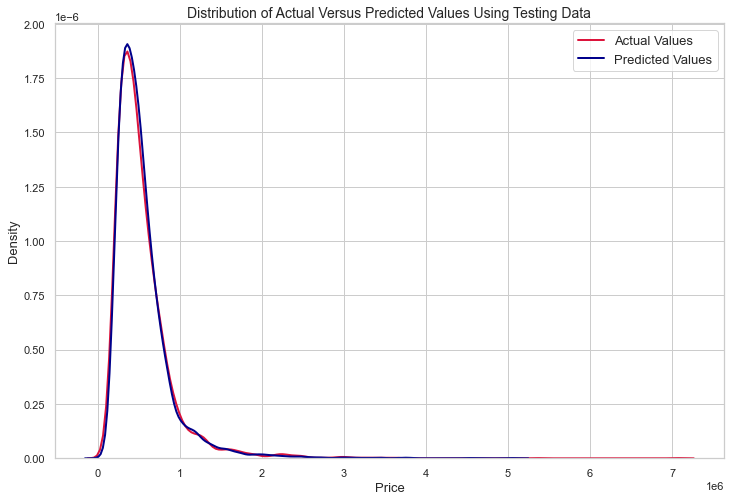

In [41]:
# Plotting the distributions
Title = 'Distribution of Actual Versus Predicted Values Using Testing Data'
DistributionPlot(y_test, yhat_XGB, "Actual Values", "Predicted Values", Title)

The distributions are very similar, which is a promising result. 

### 4.3 Plot of Residuals from Fitted Regression<a class="anchor" id="chapter4.3"></a>

Finally, I plotted the residuals:

<AxesSubplot:title={'center':'Residuals from Fitted Regression'}, xlabel="Predicted Values for 'Price'", ylabel='Absolute Residuals'>

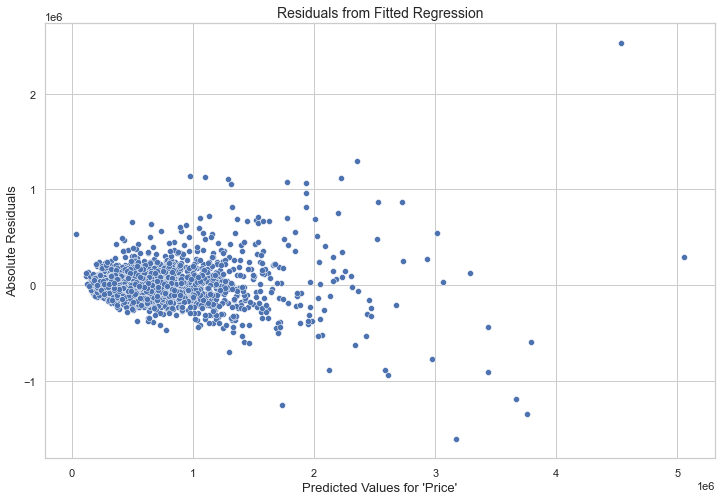

In [42]:
# Creating a new dataframe with predicted and true values
preds = pd.DataFrame({"preds": yhat_XGB, "true": y_test})

# Creating a column for residuals
preds["residuals"] = preds["true"] - preds["preds"]

# Plotting the residuals across predicted values
plt.figure(figsize=(12, 8))
plt.title("Residuals from Fitted Regression", fontsize = 14)
plt.xlabel("Predicted Values for 'Price'", fontsize = 13)
plt.ylabel("Absolute Residuals", fontsize = 13)
sns.scatterplot(data = preds, x = "preds", y = "residuals")

According to the plot, the range of the residuals appear more-or-less uniform for price predictions ranging from 0 to ~1e6, but starts to increase or "fan out" somewhat over higher ranges. This suggests that there may be some heteroskedasticity and that predictions could be less reliable at higher price ranges.

### 4.4 Limitations and Future Directions<a class="anchor" id="chapter4.4"></a>

I outline several limitations and future directions below:

* When using the testing data, there was some heteroskedasticity in the residuals, suggesting that predictions may be less reliable at higher price ranges. Future analysis could consider exploring different sets of features (i.e., dropping or adding new features) or different non-linear transformations to improve model reliability.

* There was high multicollinearity among some of the variables. From a conceptual standpoint, some variables were quite similar in nature (e.g., number of bedrooms and number of bathrooms) and could perhaps be grouped. Accordingly, future analysis should consider implementing principal components analysis (PCA) for dimensionality reduction.

* The final model's hyperparameters were tuned using Bayesian opimization with 100 evaluations. While this number was chosen for the sake of efficiency, better accuracy may be achieved by increasing the number of evaluations in addition to widening the range of potential values for each hyperparameter. 

* But as with model, performance may be improved by collecting additional data (i.e., greater samples and additional features) and feature engineering, more so than additional hyperparameter tuning.

### Thank you!

Created by Young Hun Ji